In [1]:
import random

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
import scipy.stats
import sympy
import seaborn as sns
import pandas as pd
import numba
from scipy.stats import entropy
import os
import tempfile
import logging

from pyabc import ABCSMC, RV, Distribution
from pyabc.distance import AdaptivePNormDistance, PercentileDistance

from pyabc.sampler import SingleCoreSampler
from pyabc.visualization import plot_kde_1d, plot_kde_2d

First, define the simulator.  
N = population size  
s_cnv = fitness benefit of CNVs  
s_snv = fitness benefit of SNVs  
m_cnv = probability mutation to CNV  
m_snv = probability mutation to SNV


In [2]:
def CNVsimulator(N, s_snv, m_snv, generation, seed=None, **kwargs):
    """ CNV evolution simulator
    Simulates CNV and SNV evolution for 267 generations
    Returns proportion of the population with a CNV per generation as 1d np.array of length 267
    
    Parameters
    -------------------
    N : int
        population size  
    s_snv : float
        fitness benefit of SNVs  
    m_snv : float 
        probability mutation to SNV   
    gen : np.array, 1d 
        with generations 0 through the end of simulation
    seed : int
    
    Depending on what the downstream inference is, the following parameters are can be passed
    cnv_params : np.array, 1d of length dim_param
        Parameter vector with the log 10 selection coefficient and log 10 cnv mutation rate, for use with SNPE or to build observed data
    parameters : instance of parameters
        has attribute s, float, log 10 selection coefficient
        has attribute m, float, log 10 cnv mutation rate
        for use with pyABC
    """
    cnv_params = kwargs.get('cnv_params', None)
    parameters = kwargs.get('parameters', None)
    
    if seed is not None:
        np.random.seed(seed=seed)
    else:
        np.random.seed()

    
    assert N > 0
    N = np.uint64(N)
    if isinstance(cnv_params, np.ndarray):
        s_cnv, m_cnv = np.power(10,cnv_params)
    else:
        s_cnv = np.power(10,parameters.s)
        m_cnv = np.power(10,parameters.m)
    
    w = np.array([1, 1 + s_cnv, 1 + s_snv])
    S = np.diag(w)
    
    # make transition rate array
    # make transition rate array
    M = np.array([[1 - m_cnv - m_snv, 0, 0],
                [m_cnv, 1, 0],
                [m_snv, 0, 1]])
    assert np.allclose(M.sum(axis=0), 1)
    
    # mutation and selection
    E = M @ S

    # rows are genotypes
    n = np.zeros(3)
    n[0] = N  
    
    # follow proportion of the population with CNV
    # here rows with be generation, columns (there is only one) is replicate population
    p_cnv = []
    
    # run simulation to generation 267
    for t in generation:    
        p = n/N  # counts to frequencies
        p_cnv.append(p[1])  # frequency of CNVs
        p = E @ p.reshape((3, 1))  # natural selection + mutation        
        p /= p.sum()  # rescale proportions
        n = np.random.multinomial(N, p) # random genetic drift
    
    #these were the generations observed in Lauer et al. 2018, so the ones we will use here
    exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])
    
    return np.transpose(p_cnv)[exp_gen]

"Observed data"  
Using 9 simulations with known parameters for observed data

In [3]:
# pop size, fitness SNVs, mutation rate SNVs, number of generations
N = 3e8
s_snv=0.001
m_snv=1e-5
generation = np.array(range(0,268))
seed_true = 1

# true parameters
true_params = np.log10(np.array([.001, 1e-5]))
labels_params = ['CNV fitness effect', 'CNV mutation rate']

# our actual observation.
data_observed = CNVsimulator(N=N, s_snv=s_snv, m_snv=m_snv, cnv_params=true_params, generation=generation, seed=seed_true)
exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267]).astype(str)
dict_observed = {}
i = 0
for keys in exp_gen: 
    dict_observed[keys] = data_observed[i]
    i+=1

Wrapper, pyABC requires simulation to return a dictionary

In [4]:
def simulate_pyabc(parameters, N=N, s_snv=s_snv, m_snv=m_snv, generation=generation):
    res = CNVsimulator(N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, parameters=parameters)
    exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267]).astype(str)
    pyabc_dict = {}
    i = 0
    for keys in exp_gen: 
        pyabc_dict[keys] = res[i]
        i+=1
    return pyabc_dict

In [5]:
prior = Distribution(
    s=RV("uniform", np.log10(1e-4), np.log10(0.3)-np.log10(1e-4)),
    m=RV("uniform", np.log10(1e-12), np.log10(1e-4)-np.log10(1e-12))
)

Create the ABCSMC object, given the model, the prior, and the distance function $\rho$, which we set to PercentileDistanceFunction which is the absolute difference $|x - x_0|$ normalized to the statistics of the samples.

In [6]:
abc = ABCSMC(models=simulate_pyabc,
             parameter_priors=prior,
             distance_function=AdaptivePNormDistance(p=2),
             sampler=SingleCoreSampler(),
             population_size=30)

In [7]:
# and we define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
history = abc.new(db_path, dict_observed)

INFO:History:Start <ABCSMC(id=5, start_time=2020-05-19 15:18:41.463046, end_time=None)>


In [8]:
print("ABC-SMC run ID:", history.id)

ABC-SMC run ID: 5


In [9]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.2, max_nr_populations=5)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.003975902418441637
INFO:ABC:t: 0, eps: 0.003975902418441637.
INFO:ABC:Acceptance rate: 30 / 70 = 4.2857e-01, ESS=3.0000e+01.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=5, start_time=2020-05-19 15:18:41.463046, end_time=2020-05-19 15:18:44.305430)>


In [10]:
params, weights = history.get_distribution(0)
params.head()

name,m,s
id,,
36,-8.688730,-3.590591
37,-8.963098,-2.098631
38,-7.046623,-2.668486
39,-8.368735,-3.403697
40,-5.368646,-2.158101


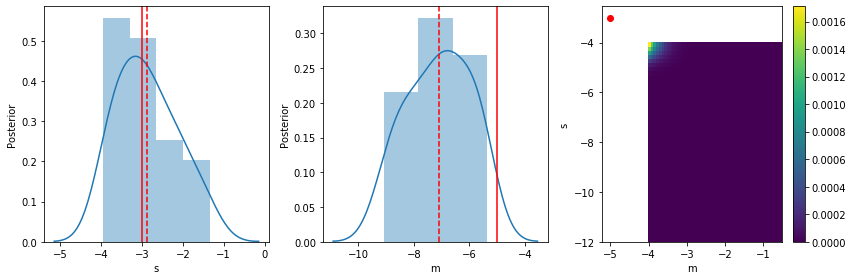

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for param_name, param_real_value, ax in zip(['s', 'm'], true_params, axes.flat):
    sns.distplot(params[param_name], hist_kws=dict(weights=weights), ax=ax)
    ax.axvline(param_real_value, color='red')
    ax.axvline(params[param_name].values @ weights, color='red', ls='--')
    ax.set(xlabel=param_name, ylabel='Posterior')
    
ax = axes[2]
plot_kde_2d(params, weights, 'm', 's', xmin=np.log10(1e-4), xmax=np.log10(0.3), ymin=np.log10(1e-12), ymax=np.log10(1e-4), 
            ax=ax, colorbar=True)
ax.plot(true_params[1], true_params[0], 'o', color='red')

fig.tight_layout()

In [14]:
np.power(10,true_params)

array([1.e-03, 1.e-05])

In [18]:
 s=RV("uniform", np.log10(1e-4), np.log10(1e-3)-np.log10(1e-4)),
    m=RV("uniform", np.log10(1e-12), np.log10(0.3)-np.log10(1e-12))

AttributeError: 'Distribution' object has no attribute 's'

In [21]:
1e-3

0.001